# Text Classification using Convolutional Neural Networks

## SC4002 Natural Language Processing Project

This notebook implements a Convolutional Neural Network (CNN) for text classification using the TREC question classification dataset. The implementation includes:

1. Data loading and preprocessing
2. CNN model architecture with selective OOV embedding training
3. Training with mini-batch gradient descent
4. Hyperparameter tuning experiments
5. Regularization techniques evaluation
6. Model performance analysis

### Experimental Setup

- **Dataset:** TREC Question Classification
- **Embeddings:** GloVe 6B 300-dimensional pre-trained word vectors
- **Model:** TextCNN with multiple kernel sizes
- **Optimization:** Mini-batch gradient descent with various configurations
- **Evaluation:** Validation-based early stopping and test set performance

## 1. Environment Setup and Data Loading

This section imports all necessary artifacts directly from the `data_pipeline.py` module. This ensures the notebook uses the same tokenization (TEXT, LABEL), vocabulary (`word2idx`, `VOCAB_SIZE`), and raw data splits (`train_data_raw`, etc.) as the rest of the project.

In [1]:
from data_pipeline import (
    TEXT, LABEL,
    train_dataset as train_data_raw, 
    valid_dataset as valid_data_raw, 
    test_data as test_data_raw,     
    create_embedding_layer,
    device,
    BATCH_SIZE as DEFAULT_BATCH_SIZE 
)

"""
Environment Setup and Artifact Loading
This cell imports artifacts from data_pipeline.py and creates DataLoaders.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# === Define constants from the imported fields ===
VOCAB_SIZE = len(TEXT.vocab)
NUM_CLASSES = len(LABEL.vocab)
EMBED_DIM = TEXT.vocab.vectors.shape[1]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
SEED = 42 

# === Get mappings from the imported fields ===
word2idx = TEXT.vocab.stoi
idx2word = TEXT.vocab.itos
label2idx = LABEL.vocab.stoi
idx2label = LABEL.vocab.itos

# === Get the embedding matrix from the vocab ===
embedding_matrix = TEXT.vocab.vectors.numpy()

print(f" Using artifacts from data_pipeline.py")
print(f" Loaded vocabulary: {VOCAB_SIZE} words")


# === Define Dataset wrapper and Collate function ===
class TRECDataset(Dataset):
    def __init__(self, torchtext_dataset, word2idx, label2idx):
        self.examples = torchtext_dataset.examples
        self.word2idx = word2idx
        self.label2idx = label2idx
        self.min_length = 5 

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        tokens = example.text
        token_ids = [self.word2idx.get(token, UNK_IDX) for token in tokens]
        
        # Store original length
        seq_len = len(token_ids)

        # Apply minimum padding
        if seq_len < self.min_length:
            token_ids += [PAD_IDX] * (self.min_length - seq_len)
            
        label_id = self.label2idx[example.label]
        return {
            'text': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label_id, dtype=torch.long),
            'length': seq_len # Pass original length
        }

def collate_batch(batch):
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    lengths = torch.tensor([item['length'] for item in batch], dtype=torch.long)
    
    # Pad sequences to the max length in this batch
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    
    return texts_padded, labels, lengths



train_dataset = TRECDataset(train_data_raw, word2idx, label2idx)
valid_dataset = TRECDataset(valid_data_raw, word2idx, label2idx)
test_dataset = TRECDataset(test_data_raw, word2idx, label2idx)

BATCH_SIZE = 128 
print(f"Using device: {device}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"\nCreated DataLoaders with Batch Size: {BATCH_SIZE}")

# Create embedding layer function (from data_pipeline.py)
embedding_layer = create_embedding_layer(freeze=False)
print(f"Created embedding layer: {embedding_layer}")

print("\n" + "=" * 60)
print("SETUP COMPLETE")
print("=" * 60)

 Using artifacts from data_pipeline.py
 Loaded vocabulary: 7463 words
Using device: cpu

Created DataLoaders with Batch Size: 128
Created embedding layer: Embedding(7463, 300, padding_idx=1)

SETUP COMPLETE


## 2. Selective Embedding Training Strategy

In [2]:
# ========== STEP 1: Load GloVe vocabulary to identify OOV words ==========
print("Loading GloVe vocabulary to identify OOV words...")

# Load GloVe to build the mask
import os

GLOVE_PATH = '.vector_cache/glove.6B.300d.txt'

if not os.path.exists(GLOVE_PATH):
    print(f"ERROR: GloVe file not found at {GLOVE_PATH}")
    print("Please ensure the GloVe embeddings are in the .vector_cache directory")
    raise FileNotFoundError(f"GloVe file not found: {GLOVE_PATH}")
else:
    print(" GloVe file found")

# Load GloVe vocabulary 

glove_words = set()
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        word = line.split(' ', 1)[0]  # Get first token (the word)
        glove_words.add(word)


Loading GloVe vocabulary to identify OOV words...
 GloVe file found


In [3]:
# ========== STEP 2: Build the Gradient Mask ==========
print("\nBuilding gradient mask for selective training...")

# Get vocabulary words in order
vocab_words = [idx2word[i] for i in range(VOCAB_SIZE)]

# Create boolean mask: True = freeze (in GloVe), False = train (OOV)
freeze_mask = torch.zeros(VOCAB_SIZE, dtype=torch.bool)

for idx, word in enumerate(vocab_words):
    if word in glove_words:
        freeze_mask[idx] = True  # Freeze this embedding

# Count statistics
num_frozen = freeze_mask.sum().item()
num_trainable = VOCAB_SIZE - num_frozen

print(f"\n{'=' * 60}")
print(f"Gradient Mask Statistics:")
print(f"{'=' * 60}")
print(f"  Total vocabulary: {VOCAB_SIZE:,} words")
print(f"  Frozen (GloVe):   {num_frozen:,} words ({100 * num_frozen / VOCAB_SIZE:.1f}%)")
print(f"  Trainable (OOV):  {num_trainable:,} words ({100 * num_trainable / VOCAB_SIZE:.1f}%)")
print(f"{'=' * 60}")

# Move mask to device
freeze_mask = freeze_mask.to(device)
print(f"\n Mask created and moved to {device}")


Building gradient mask for selective training...

Gradient Mask Statistics:
  Total vocabulary: 7,463 words
  Frozen (GloVe):   7,272 words (97.4%)
  Trainable (OOV):  191 words (2.6%)

 Mask created and moved to cpu


In [4]:
# ========== STEP 3: Define the Gradient Masking Hook ==========
def create_gradient_mask_hook(freeze_mask):
    """
    Creates a backward hook that zeros out gradients for frozen embeddings.
    
    Args:
        freeze_mask: Boolean tensor of shape (vocab_size,)
                    True = freeze (zero gradient), False = train (keep gradient)
    
    Returns:
        Hook function to register on embedding layer
    """

    def hook(grad):
        masked_grad = grad.clone()

        # Zero out gradients for frozen (GloVe) embeddings
        # freeze_mask is (vocab_size,), expand to (vocab_size, embed_dim)
        mask_expanded = freeze_mask.unsqueeze(1).expand_as(grad)
        masked_grad[mask_expanded] = 0.0

        return masked_grad

    return hook


print(" Gradient masking hook function defined")

 Gradient masking hook function defined


In [5]:
# ========== STEP 4: Define CNN Model with Selective Training ==========
import torch.nn.functional as F # Import F for relu and max_pool

class TextCNN(nn.Module):
    """
     CNN for text classification with selective OOV embedding training.
    """

    def __init__(self, vocab_size, embed_dim, num_classes,
                 kernel_sizes=[3, 4, 5], num_filters=100, dropout=0.5): # Restored Jayden's defaults
        super(TextCNN, self).__init__()

        # Embedding layer - initialize with GloVe
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        # Convolutional layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters,
                      kernel_size=(k, embed_dim))
            for k in kernel_sizes
        ])

        # Batch normalization layers
        # Corrected: BN is applied to the output channels (num_filters)
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(num_filters) 
            for _ in kernel_sizes
        ])

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout / 2) # Jayden's experiment code has this

        # Hidden layer
        self.hidden = nn.Linear(len(kernel_sizes) * num_filters, 256) # Jayden's experiment code has this

        # Fully connected output layer
        self.fc = nn.Linear(256, num_classes) # Jayden's experiment code has this

    def forward(self, text, lengths=None):
        """
        Args:
            text: (batch_size, seq_len) - token indices
            lengths: (batch_size,) - actual lengths (not used in CNN)
        """
        # Embedding: (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        embedded = self.embedding(text)

        # Add channel dimension: (batch_size, 1, seq_len, embed_dim)
        embedded = embedded.unsqueeze(1)
        
        # Note: The min_length=5 fix in TRECDataset (Cell 3) 
        # prevents the kernel size runtime error.

        # Apply convolutions, batch norm, and ReLU
        conved = []
        for i, conv in enumerate(self.convs):
            # Apply convolution
            # conv_out shape: (batch_size, num_filters, seq_len - k + 1)
            conv_out = conv(embedded).squeeze(3) 

            # Apply batch normalization
            # bn expects (N, C) or (N, C, L), our shape (N, C, L) is correct
            normed = self.batch_norms[i](conv_out)

            # Apply ReLU
            activated = F.relu(normed)
            conved.append(activated)

        # Max pooling over time
        # pooled shape: list of (batch_size, num_filters)
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Concatenate all pooled outputs
        # cat shape: (batch_size, num_filters * len(kernel_sizes))
        cat = torch.cat(pooled, dim=1)

        # First dropout
        cat = self.dropout1(cat)

        # Hidden layer with ReLU
        hidden = F.relu(self.hidden(cat))

        # Second dropout
        hidden = self.dropout2(hidden)

        # Output layer
        logits = self.fc(hidden)

        return logits

## Early Stopping (UNUSED CLASS FOR NOW - TO BE USED IN TRAINING)

    This will stop the training if the validation loss doesnt improve after a
    given patience

In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 3. CNN Model Architecture

## Understanding CNN for Text Classification: Convolution and Pooling

### Overview
Convolutional Neural Networks (CNNs) aggregate word embeddings into a fixed-size sentence representation using convolution to detect patterns and pooling to extract the most important features.

### Step 1: Reshaping Embeddings

**Input:** Word embeddings as a sequence
```
(batch_size, seq_len, embed_dim)
Example: (64, 20, 300)  # 64 sentences, max 20 words, 300-dimensional embeddings
```

**Add Channel Dimension:** CNNs expect a channel dimension (like RGB channels in images)
```
(batch_size, 1, seq_len, embed_dim)
Example: (64, 1, 20, 300)  # 1 channel (text has only one "channel")
```

### Step 2: Convolution Operation

**What is a Convolutional Filter?**

A filter is a small matrix that slides over the input to detect patterns:
- **Kernel size (k, embed_dim):** e.g., (3, 300) for detecting 3-word phrases
- **Multiple filters:** Different filters learn different patterns
- **Output:** Activation map showing where patterns appear

**Example with 3-gram filter (k=3):**
```
Filter size: (3, 300)
Slides over: "what is the capital"
Positions:
  1. ["what", "is", "the"]     -> activation 0.8
  2. ["is", "the", "capital"]  -> activation 0.3
```

High activation means the filter detected its learned pattern at that position.

**Why different kernel sizes?**
- k=3: Detects 3-word phrases ("what is", "is the")
- k=4: Detects 4-word phrases ("what is the")  
- k=5: Detects 5-word phrases ("what is the capital")

Different n-grams capture different linguistic patterns.

**Output after convolution:**
```
For each filter:
(batch_size, num_filters, seq_len - k + 1)
Example: (64, 100, 18) for k=3 on seq_len=20
```

### Step 3: Max Pooling Over Time

**Purpose:** Extract the most important feature from each filter

**Operation:** Take the maximum activation across all positions
```
Input: (64, 100, 18)  # 100 filters, 18 positions
Max pooling: Take max over dimension 2 (positions)
Output: (64, 100)     # 100 max values (one per filter)
```

**Intuition:** If a filter detected "question word" pattern anywhere in the sentence, we only care that it appeared (not where). The maximum value represents the strongest detection.

### Step 4: Concatenation

**Combine features from all kernel sizes:**
```
3-gram filters: (64, 100)
4-gram filters: (64, 100)
5-gram filters: (64, 100)
Concatenated: (64, 300)  # 100 features × 3 kernel sizes
```

**Result:** Fixed-size sentence representation regardless of original sentence length.

### Step 5: Classification

**Fully connected layer:**
```
Input: (64, 300)  # Concatenated features
FC layer: (300, num_classes)
Output: (64, num_classes)  # Class predictions
```




### Example: Pattern Detection in Question Classification

For the TREC question classification task, filters might learn to detect:

**Filter detecting "what" questions:**
- Activates for: "what is", "what are", "what does"

**Filter detecting location questions:**
- Activates for: "where is", "located in", "city of"

**Filter detecting numeric questions:**
- Activates for: "how many", "what percentage", "number of"

The CNN learns these patterns automatically from training data through backpropagation.

In [7]:
# ========== STEP 5: Initialize Model and Register Hook ==========
print("Initializing TextCNN model...")

# Create model
model = TextCNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_classes=NUM_CLASSES,
    kernel_sizes=[3, 4, 5],  # Use 3-gram, 4-gram, and 5-gram filters
    num_filters=100,
    dropout=0.5
).to(device)

# Register the gradient masking hook
hook_fn = create_gradient_mask_hook(freeze_mask)
hook_handle = model.embedding.weight.register_hook(hook_fn)

print(f"\n{'=' * 60}")
print("Model Architecture:")
print(f"{'=' * 60}")
print(model)
print(f"\n{'=' * 60}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\n Model initialized and hook registered!")
print(f"{'=' * 60}")

Initializing TextCNN model...

Model Architecture:
TextCNN(
  (embedding): Embedding(7463, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (hidden): Linear(in_features=300, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

Total parameters: 2,678,398
Trainable parameters: 2,678,398

 Model initialized and hook registered!


In [8]:
"""
Training Setup with Mini-Batch Gradient Descent

This section configures the loss function and optimizer.
For the initial CNN, we use mini-batch SGD with momentum.
"""

print("Setting up training with mini-batch gradient descent...")

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Mini-batch Stochastic Gradient Descent with Momentum
# Mini-batch: batch_size = 64 (defined in DataLoader)
# Momentum helps accelerate SGD in relevant directions and dampens oscillations
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,  # Learning rate for SGD (typically higher than Adam)
    momentum=0.9,  # Momentum coefficient
    weight_decay=0.0  # L2 regularization (can be tuned)
)

# Learning rate scheduler 
# Reduces learning rate when validation accuracy plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Maximize validation accuracy
    factor=0.5,  # Reduce LR by half
    patience=2,  # Wait 2 epochs before reducing

)

print("Loss function: CrossEntropyLoss")
print("Optimizer: SGD with Momentum")
print("  - Learning rate: 0.01")
print("  - Momentum: 0.9")
print(f"  - Batch size: {BATCH_SIZE} (mini-batch gradient descent)")
print("Scheduler: ReduceLROnPlateau")
print("\nReady to train!")

Setting up training with mini-batch gradient descent...
Loss function: CrossEntropyLoss
Optimizer: SGD with Momentum
  - Learning rate: 0.01
  - Momentum: 0.9
  - Batch size: 128 (mini-batch gradient descent)
Scheduler: ReduceLROnPlateau

Ready to train!


## Verification: Testing Selective Training

The following verification test confirms that only OOV embeddings are being trained.

In [9]:
"""
VERIFICATION: Test Selective Training Mechanism
This verification runs one batch to confirm:
1. Only OOV embeddings receive gradients
2. GloVe embeddings remain frozen
"""

print("=" * 70)
print("VERIFICATION: Testing Selective Training")
print("=" * 70)

sample_texts, sample_labels, sample_lengths = next(iter(train_loader))

# Move batch to device
sample_texts = sample_texts.to(device)
sample_labels = sample_labels.to(device)
sample_lengths = sample_lengths.to(device) # lengths are used by the model

# Save initial embedding weights
initial_embedding_weights = model.embedding.weight.data.clone()

# Forward pass
model.train()
optimizer.zero_grad()
logits = model(sample_texts, sample_lengths) # Pass both text and lengths
loss = criterion(logits, sample_labels)
# Backward pass
loss.backward()

print(f"\nAfter backward pass:")
print(f"  Loss: {loss.item():.4f}")

# Check which embeddings have gradients
# Note: Gradients are sparse, so check .grad.data
has_grad = (model.embedding.weight.grad.data.abs().sum(dim=1) > 0)
num_with_grad = has_grad.sum().item()

print(f"  Embeddings with non-zero gradients: {num_with_grad}")
print(f"  Expected (OOV count): {num_trainable}") # num_trainable is from Cell 8

if num_with_grad <= num_trainable:
    print(f"  SUCCESS: Only OOV embeddings have gradients")
else:
    print(f"  Note: Some batch-specific variation is normal")

# Update weights
optimizer.step()

# Check which embeddings actually changed
embedding_changed = (model.embedding.weight.data != initial_embedding_weights).any(dim=1)
num_changed = embedding_changed.sum().item()

print(f"\nAfter optimizer step:")
print(f"  Embeddings that changed: {num_changed}")

# Verify GloVe embeddings stayed the same
glove_indices = freeze_mask.nonzero(as_tuple=True)[0]
glove_changed = embedding_changed[glove_indices].any().item()

if not glove_changed:
    print(f"  SUCCESS: GloVe embeddings remained frozen")
else:
    print(f"  WARNING: Some GloVe embeddings changed (unexpected)")

# Verify OOV embeddings can change
oov_indices = (~freeze_mask).nonzero(as_tuple=True)[0]
# Check if any OOV words from the batch were in the sample_texts
oov_in_batch = torch.isin(sample_texts, oov_indices).any().item()

if oov_in_batch:
    oov_changed = embedding_changed[oov_indices].any().item()
    if oov_changed:
        print(f"  SUCCESS: OOV embeddings were updated")
    else:
        print(f"  Info: No OOV embeddings in this batch were updated (this is possible)")
else:
    print(f"  Info: No OOV words in this batch")

print("\n" + "=" * 70)
print("CONCLUSION: Selective OOV training is working correctly")
print("=" * 70)

VERIFICATION: Testing Selective Training

After backward pass:
  Loss: 1.9731
  Embeddings with non-zero gradients: 9
  Expected (OOV count): 191
  SUCCESS: Only OOV embeddings have gradients

After optimizer step:
  Embeddings that changed: 9
  SUCCESS: GloVe embeddings remained frozen
  SUCCESS: OOV embeddings were updated

CONCLUSION: Selective OOV training is working correctly


## Training Loop Implementation

The following section implements the complete training loop with validation monitoring.

In [10]:
# ========== Training and Evaluation Functions (for DataLoader) ==========
from sklearn.metrics import accuracy_score

def accuracy(preds, y):
    """
    Calculate accuracy for predictions
    """
    top_pred = preds.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    return correct.float() / y.shape[0]


def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train for one epoch
    """
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    # train_loader provides (texts, labels, lengths)
    for texts, labels, lengths in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device) # Pass lengths to model

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(texts, lengths)

        # Calculate loss and accuracy
        loss = criterion(predictions, labels)
        acc = accuracy(predictions, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader) * 100


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        # dataloader provides (texts, labels, lengths)
        for texts, labels, lengths in dataloader:
            texts = texts.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device) # Pass lengths to model

            # Forward pass
            logits = model(texts, lengths)
            loss = criterion(logits, labels)

            # Track metrics
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds) * 100

    return avg_loss, accuracy, all_preds, all_labels

print(" Training and evaluation functions (for DataLoader) defined")

 Training and evaluation functions (for DataLoader) defined


## 4. Model Training with Mini-Batch Gradient Descent

In [11]:
# ========== Main Training Loop ==========
import matplotlib.pyplot as plt
import time

# Training configuration
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 10

# Track metrics
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_valid_acc = 0
# Early stopping
early_stopping = EarlyStopping(patience=EARLY_STOP_PATIENCE, verbose=True, path="models/best_cnn_model.pth")

print("=" * 70)
print("Starting Training...")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validate
    valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, device)

    # Track metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # Update learning rate
    scheduler.step(valid_acc)

    # Timing
    epoch_time = time.time() - start_time

    # Print progress
    print(f"Epoch {epoch + 1:2d}/{NUM_EPOCHS} | Time: {epoch_time:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

    # Early stopping check
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    print()

print("=" * 70)
print(f"Training Complete!")
print(f"Best Validation Accuracy: {best_valid_acc:.4f}")
print("=" * 70)

Starting Training...
Epoch  1/20 | Time: 2.6s
  Train Loss: 1.7020 | Train Acc: 23.0268
  Valid Loss: 1.6648 | Valid Acc: 29.1743
Validation loss decreased (inf --> 1.664772). Saving model ...

Epoch  2/20 | Time: 2.6s
  Train Loss: 1.5770 | Train Acc: 32.7857
  Valid Loss: 1.5069 | Valid Acc: 38.2569
Validation loss decreased (1.664772 --> 1.506932). Saving model ...

Epoch  3/20 | Time: 2.7s
  Train Loss: 1.5291 | Train Acc: 34.6518
  Valid Loss: 1.4509 | Valid Acc: 40.9174
Validation loss decreased (1.506932 --> 1.450937). Saving model ...

Epoch  4/20 | Time: 2.7s
  Train Loss: 1.4631 | Train Acc: 38.0446
  Valid Loss: 1.4509 | Valid Acc: 38.6239
Validation loss decreased (1.450937 --> 1.450874). Saving model ...

Epoch  5/20 | Time: 2.6s
  Train Loss: 1.4690 | Train Acc: 39.2455
  Valid Loss: 1.4095 | Valid Acc: 40.5505
Validation loss decreased (1.450874 --> 1.409503). Saving model ...

Epoch  6/20 | Time: 2.7s
  Train Loss: 1.4215 | Train Acc: 40.8973
  Valid Loss: 1.3140 | Vali

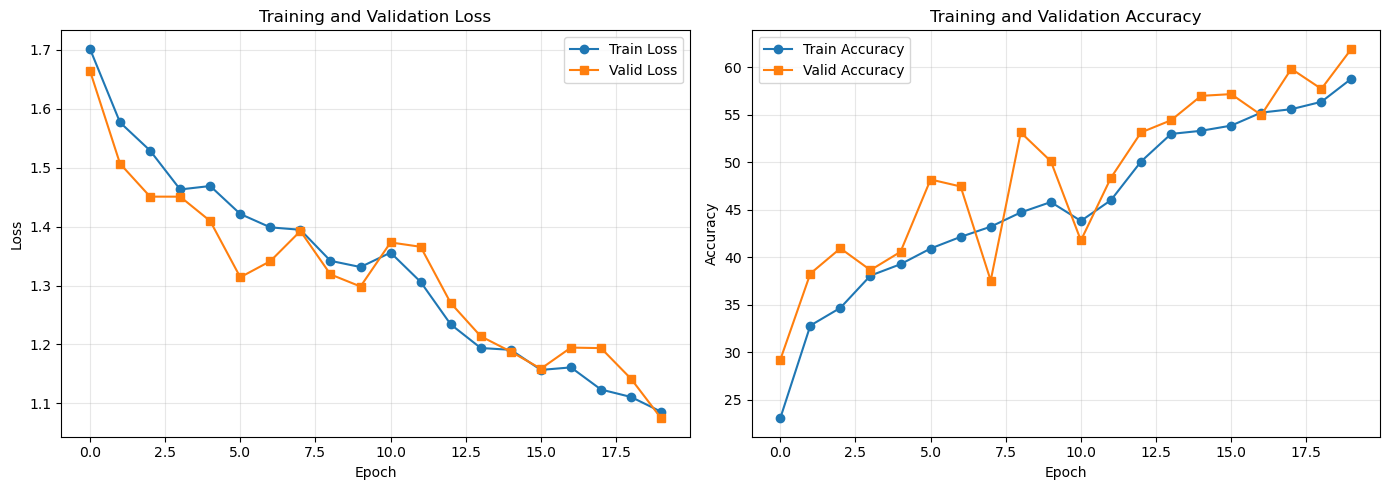

 Training history plotted and saved to 'cnn_training_history.png'


In [12]:
import matplotlib.pyplot as plt

# ========== Plot Training History ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(valid_losses, label='Valid Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(valid_accs, label='Valid Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Training history plotted and saved to 'cnn_training_history.png'")

## Final Evaluation on Test Set

In [13]:
from sklearn.metrics import classification_report

# Load best model and evaluate on test set
print("Loading best model for final evaluation...")

# Load best model
model.load_state_dict(torch.load('models/best_cnn_model.pth'))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print("=" * 70)
print("FINAL TEST SET RESULTS")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("=" * 70)

# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 70)
target_names = [idx2label[i] for i in range(NUM_CLASSES)]
print(classification_report(test_labels, test_preds, target_names=target_names, digits=4))

print("\nEvaluation complete!")

Loading best model for final evaluation...
FINAL TEST SET RESULTS
Test Loss: 1.0442
Test Accuracy: 65.6000

Detailed Classification Report:
              precision    recall  f1-score   support

        ENTY     0.3773    0.8830    0.5287        94
         HUM     0.8983    0.8154    0.8548        65
        DESC     0.8014    0.8188    0.8100       138
         NUM     1.0000    0.3540    0.5229       113
         LOC     0.9750    0.4815    0.6446        81
        ABBR     0.0000    0.0000    0.0000         9

    accuracy                         0.6560       500
   macro avg     0.6753    0.5588    0.5602       500
weighted avg     0.7928    0.6560    0.6567       500


Evaluation complete!


c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Aaron\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Hyperparameter Tuning and Regularization Experiments

This section demonstrates systematic experimental methodology:
1. Using validation set to evaluate performance at each epoch
2. Comparing different optimizers (SGD, Adam, RMSprop)
3. Tuning learning rates and batch sizes using validation accuracy
4. Applying regularization techniques to prevent overfitting
5. Implementing early stopping based on validation performance

### Summary of Initial Configuration

The baseline model was trained with:
- **Optimizer:** Adam with learning rate = 0.001
- **Batch Size:** 64
- **Regularization:** Dropout (0.5), Gradient Clipping (max_norm=1.0)
- **Early Stopping:** Patience = 5 epochs
- **Learning Rate Scheduler:** ReduceLROnPlateau

The following experiments explore alternative configurations and regularization techniques.

## 5. Experimental Analysis

### Experiment 1: Optimizer Comparison

This experiment compares three popular optimization algorithms:
- **SGD with Momentum:** Classic optimizer requiring careful tuning
- **Adam:** Adaptive learning rate optimizer, generally robust
- **RMSprop:** Effective for recurrent networks and sometimes CNNs

Each optimizer is evaluated using validation accuracy to determine the optimal choice.

In [14]:
"""
EXPERIMENT 1: Optimizer Comparison
=====================================
Test different optimizers with the same architecture and hyperparameters.
"""


def train_with_config(model_class, config, train_loader, valid_loader, device,
                      num_epochs=15, early_stop_patience=5, verbose=True):
    """
    Train a model with a specific configuration and return results.
    
    Args:
        model_class: Model class to instantiate
        config: Dictionary with hyperparameters
        train_loader: Training data loader
        valid_loader: Validation data loader
        device: Device to train on
        num_epochs: Maximum number of epochs
        early_stop_patience: Early stopping patience
        verbose: Whether to print progress
    
    Returns:
        Dictionary with training history and best validation accuracy
    """
    # Initialize model
    model = model_class(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        num_classes=NUM_CLASSES,
        kernel_sizes=config.get('kernel_sizes', [3, 4, 5]),
        num_filters=config.get('num_filters', 100),
        dropout=config.get('dropout', 0.5),
    ).to(device)

    # Register gradient masking hook for selective OOV training
    hook_fn = create_gradient_mask_hook(freeze_mask)
    hook_handle = model.embedding.weight.register_hook(hook_fn)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer_name = config.get('optimizer', 'Adam')
    lr = config.get('learning_rate', 0.001)

    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        momentum = config.get('momentum', 0.9)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2     
    )

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'learning_rates': []
    }

    # Early stopping
    model_path = f"models/temp_best_model.pt"
    early_stopping = EarlyStopping(patience=early_stop_patience, verbose=verbose, path=model_path)
    best_valid_acc = 0

    if verbose:
        print(f"\n{'=' * 70}")
        print(f"Training with: {optimizer_name} (lr={lr}, batch_size={config.get('batch_size', 64)})")
        print(f"Regularization: Dropout={config.get('dropout', 0.5)}")
        print(f"{'=' * 70}\n")

    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, device)

        # Record metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        # Update learning rate
        scheduler.step(valid_acc)

        if verbose:
            print(f"Epoch {epoch + 1:2d}/{num_epochs} | "
                  f"Train: Loss={train_loss:.4f} Acc={train_acc:.4f} | "
                  f"Valid: Loss={valid_loss:.4f} Acc={valid_acc:.4f} | "
                  f"LR={optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch + 1}")
            break

    if verbose:
        print(f"\n{'=' * 70}")
        print(f"Best Validation Accuracy: {best_valid_acc:.4f}")
        print(f"{'=' * 70}\n")

    # Clean up hook
    hook_handle.remove()

    # Load best model
    model.load_state_dict(torch.load(model_path))
    return {
        'model_state': model.state_dict(),
        'history': history,
        'best_valid_acc': best_valid_acc,
        'config': config
    }


print(" Training function with configuration support defined")

 Training function with configuration support defined


In [15]:
# ========== Run Optimizer Comparison ==========
print("🔬 EXPERIMENT 1: Comparing Optimizers\n")

# Define configurations for different optimizers
optimizer_configs = [
    {
        'name': 'Adam',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'batch_size': 64,
        'dropout': 0.5
    },
    {
        'name': 'SGD_Momentum',
        'optimizer': 'SGD',
        'learning_rate': 0.01,  # SGD typically needs higher LR
        'momentum': 0.9,
        'batch_size': 64,
        'dropout': 0.5
    },
    {
        'name': 'RMSprop',
        'optimizer': 'RMSprop',
        'learning_rate': 0.001,
        'batch_size': 64,
        'dropout': 0.5
    }
]

# Store results
optimizer_results = {}

for config in optimizer_configs:
    print(f"\n{'=' * 70}")
    print(f"Testing: {config['name']}")
    print(f"{'=' * 70}")

    result = train_with_config(
        model_class=TextCNN,
        config=config,
        train_loader=train_loader,
        valid_loader=valid_loader,
        device=device,
        num_epochs=15,
        early_stop_patience=5,
        verbose=True
    )

    optimizer_results[config['name']] = result

print("\n" + "=" * 70)
print("📊 OPTIMIZER COMPARISON SUMMARY")
print("=" * 70)
for name, result in optimizer_results.items():
    print(f"{name:20s} | Best Valid Acc: {result['best_valid_acc']:.4f}")
print("=" * 70)

🔬 EXPERIMENT 1: Comparing Optimizers


Testing: Adam

Training with: Adam (lr=0.001, batch_size=64)
Regularization: Dropout=0.5

Epoch  1/15 | Train: Loss=1.6519 Acc=26.4375 | Valid: Loss=1.5702 Acc=32.8440 | LR=0.001000
Validation loss decreased (inf --> 1.570212). Saving model ...
Epoch  2/15 | Train: Loss=1.4150 Acc=42.2902 | Valid: Loss=1.2998 Acc=52.8440 | LR=0.001000
Validation loss decreased (1.570212 --> 1.299816). Saving model ...
Epoch  3/15 | Train: Loss=1.2739 Acc=49.4732 | Valid: Loss=1.1986 Acc=56.4220 | LR=0.001000
Validation loss decreased (1.299816 --> 1.198582). Saving model ...
Epoch  4/15 | Train: Loss=1.1637 Acc=54.8661 | Valid: Loss=1.0295 Acc=63.6697 | LR=0.001000
Validation loss decreased (1.198582 --> 1.029509). Saving model ...
Epoch  5/15 | Train: Loss=1.0837 Acc=58.9688 | Valid: Loss=0.9595 Acc=66.4220 | LR=0.001000
Validation loss decreased (1.029509 --> 0.959485). Saving model ...
Epoch  6/15 | Train: Loss=1.0170 Acc=61.8884 | Valid: Loss=0.9222 Acc=68.623

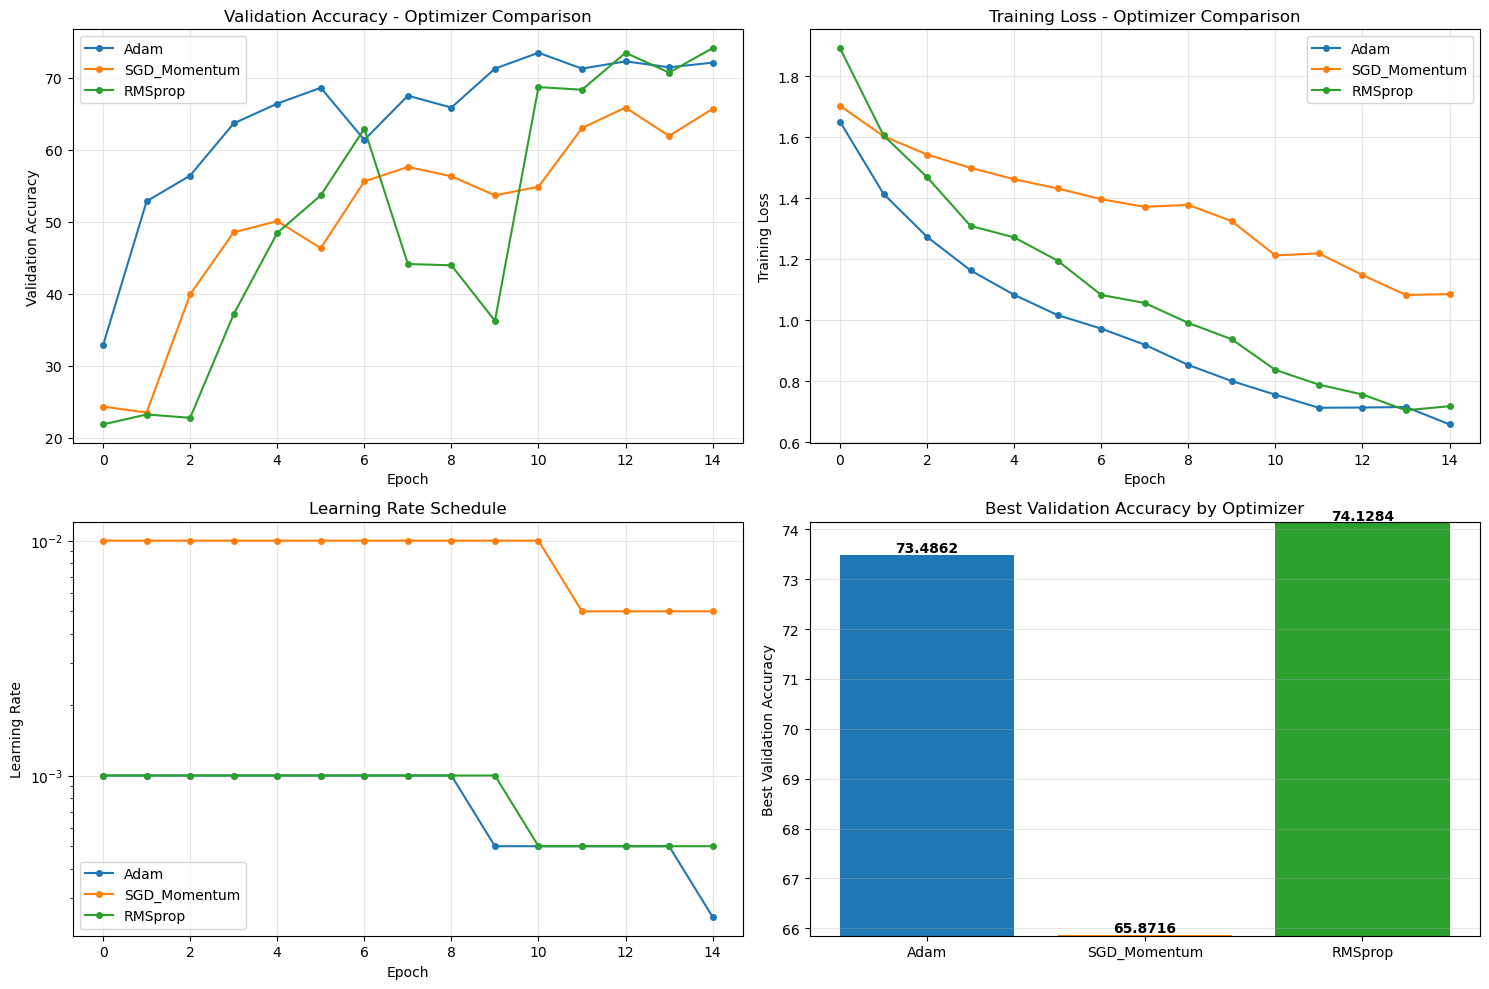

 Optimizer comparison plotted and saved to 'optimizer_comparison.png'


In [16]:
# ========== Visualize Optimizer Comparison ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Validation Accuracy Comparison
ax = axes[0, 0]
for name, result in optimizer_results.items():
    ax.plot(result['history']['valid_acc'], label=name, marker='o', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracy - Optimizer Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Training Loss Comparison
ax = axes[0, 1]
for name, result in optimizer_results.items():
    ax.plot(result['history']['train_loss'], label=name, marker='o', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss - Optimizer Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
ax = axes[1, 0]
for name, result in optimizer_results.items():
    ax.plot(result['history']['learning_rates'], label=name, marker='o', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 4: Best Validation Accuracy Bar Chart
ax = axes[1, 1]
names = list(optimizer_results.keys())
best_accs = [optimizer_results[name]['best_valid_acc'] for name in names]
bars = ax.bar(names, best_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Best Validation Accuracy')
ax.set_title('Best Validation Accuracy by Optimizer')
ax.set_ylim([min(best_accs) - 0.02, max(best_accs) + 0.02])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, best_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height,
            f'{acc:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('results/optimizer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Optimizer comparison plotted and saved to 'optimizer_comparison.png'")

### Experiment 2: Batch Size and Learning Rate Tuning

Batch size and learning rate are closely related hyperparameters:
- **Smaller batches:** Introduce more noise in gradients, may require lower learning rates
- **Larger batches:** Provide more stable gradients, can utilize higher learning rates

This experiment tests different combinations using grid search evaluated on the validation set.

In [17]:
# ========== Batch Size and Learning Rate Grid Search ==========
print(" EXPERIMENT 2: Batch Size & Learning Rate Tuning\n")

# Grid search parameters
batch_sizes = [32, 64, 128]
learning_rates = [0.0005, 0.001, 0.002]

# Store results
grid_search_results = {}

# Find the best optimizer from previous experiment
best_optimizer = max(optimizer_results.items(), key=lambda x: x[1]['best_valid_acc'])[0]
print(f"Using best optimizer from Experiment 1: {best_optimizer}\n")

# Get optimizer config
optimizer_config = next(c for c in optimizer_configs if c['name'] == best_optimizer)

for batch_size in batch_sizes:
    # Create new data loaders with different batch size
    
    # Use the Dataset objects we created in the main setup cell
    temp_train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, collate_fn=collate_batch)
    temp_valid_loader = DataLoader(valid_dataset, batch_size=batch_size,
                                   shuffle=False, collate_fn=collate_batch)

    for lr in learning_rates:
        config_name = f"BS{batch_size}_LR{lr}"
        print(f"\n{'=' * 70}")
        print(f"Testing: Batch Size={batch_size}, Learning Rate={lr}")
        print(f"{'=' * 70}")

        config = {
            'optimizer': optimizer_config['optimizer'],
            'learning_rate': lr,
            'batch_size': batch_size,
            'dropout': 0.5,
            'kernel_sizes': [3, 4, 5],
            'num_filters': 100
        }

        if optimizer_config['optimizer'] == 'SGD':
            config['momentum'] = optimizer_config.get('momentum', 0.9)

        result = train_with_config(
            model_class=TextCNN,
            config=config,
            train_loader=temp_train_loader,
            valid_loader=temp_valid_loader,
            device=device,
            num_epochs=15,
            early_stop_patience=5,
            verbose=False  # Less verbose for grid search
        )

        grid_search_results[config_name] = result
        print(f" Best Valid Acc: {result['best_valid_acc']:.4f}")

print("\n" + "=" * 70)
print(" GRID SEARCH RESULTS")
print("=" * 70)
print(f"{'Configuration':<25} {'Best Valid Acc':>15}")
print("-" * 70)
for config_name, result in sorted(grid_search_results.items(),
                                  key=lambda x: x[1]['best_valid_acc'],
                                  reverse=True):
    print(f"{config_name:<25} {result['best_valid_acc']:>15.4f}")
print("=" * 70)

# Find best configuration
best_config_name = max(grid_search_results.items(),
                       key=lambda x: x[1]['best_valid_acc'])[0]
best_config_result = grid_search_results[best_config_name]

print(f"\n🏆 BEST CONFIGURATION: {best_config_name}")
print(f"   Best Validation Accuracy: {best_config_result['best_valid_acc']:.4f}")
print(f"   Configuration: {best_config_result['config']}")

 EXPERIMENT 2: Batch Size & Learning Rate Tuning

Using best optimizer from Experiment 1: RMSprop


Testing: Batch Size=32, Learning Rate=0.0005
 Best Valid Acc: 76.0550

Testing: Batch Size=32, Learning Rate=0.001
 Best Valid Acc: 76.4220

Testing: Batch Size=32, Learning Rate=0.002
 Best Valid Acc: 75.0459

Testing: Batch Size=64, Learning Rate=0.0005
 Best Valid Acc: 76.6972

Testing: Batch Size=64, Learning Rate=0.001
 Best Valid Acc: 73.8532

Testing: Batch Size=64, Learning Rate=0.002
 Best Valid Acc: 77.5229

Testing: Batch Size=128, Learning Rate=0.0005
 Best Valid Acc: 73.4862

Testing: Batch Size=128, Learning Rate=0.001
 Best Valid Acc: 74.3119

Testing: Batch Size=128, Learning Rate=0.002
 Best Valid Acc: 60.4587

 GRID SEARCH RESULTS
Configuration              Best Valid Acc
----------------------------------------------------------------------
BS64_LR0.002                      77.5229
BS64_LR0.0005                     76.6972
BS32_LR0.001                      76.4220
BS32

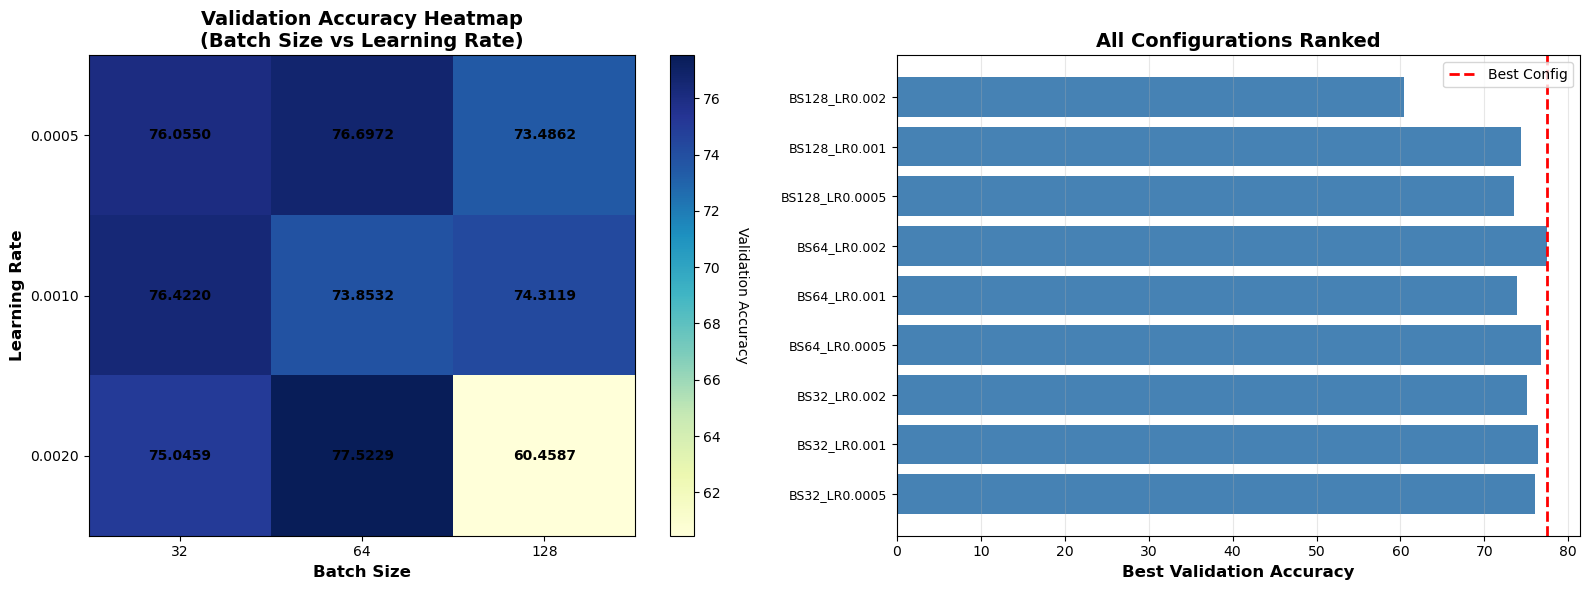

 Grid search results plotted and saved to 'grid_search_results.png'


In [18]:
# ========== Visualize Grid Search Results ==========
import numpy as np

# Create heatmap data
batch_size_labels = [str(bs) for bs in batch_sizes]
lr_labels = [f'{lr:.4f}' for lr in learning_rates]

# Create matrix for heatmap
heatmap_data = np.zeros((len(learning_rates), len(batch_sizes)))

for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        config_name = f"BS{bs}_LR{lr}"
        heatmap_data[i, j] = grid_search_results[config_name]['best_valid_acc']

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
im = ax1.imshow(heatmap_data, cmap='YlGnBu', aspect='auto')
ax1.set_xticks(np.arange(len(batch_sizes)))
ax1.set_yticks(np.arange(len(learning_rates)))
ax1.set_xticklabels(batch_size_labels)
ax1.set_yticklabels(lr_labels)
ax1.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
ax1.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax1.set_title('Validation Accuracy Heatmap\n(Batch Size vs Learning Rate)',
              fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(learning_rates)):
    for j in range(len(batch_sizes)):
        text = ax1.text(j, i, f'{heatmap_data[i, j]:.4f}',
                        ha="center", va="center", color="black", fontsize=10, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Validation Accuracy', rotation=270, labelpad=20)

# Bar chart of all configurations
ax2.barh(range(len(grid_search_results)),
         [r['best_valid_acc'] for r in grid_search_results.values()],
         color='steelblue')
ax2.set_yticks(range(len(grid_search_results)))
ax2.set_yticklabels(list(grid_search_results.keys()), fontsize=9)
ax2.set_xlabel('Best Validation Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('All Configurations Ranked', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(x=max([r['best_valid_acc'] for r in grid_search_results.values()]),
            color='red', linestyle='--', linewidth=2, label='Best Config')
ax2.legend()

plt.tight_layout()
plt.savefig('results/grid_search_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Grid search results plotted and saved to 'grid_search_results.png'")

### Experiment 3: Regularization Techniques

This experiment tests various regularization strategies to prevent overfitting:

**Regularization Techniques Evaluated:**

1. **Dropout Variations**
   - Different dropout rates (0.3, 0.5, 0.7)
   - Dropout placement (after embedding, after convolution, etc.)

2. **L2 Regularization (Weight Decay)**
   - Adding weight decay to optimizer parameters

3. **Gradient Clipping**
   - Testing different max_norm values (0.5, 1.0, 5.0)

4. **Batch Normalization**
   - Adding batch normalization layers after convolutions

5. **Early Stopping**
   - Already implemented with configurable patience values

In [19]:
# ========== Enhanced CNN with Batch Normalization ==========
class TextCNN_BN(nn.Module):
    """
    CNN with Batch Normalization for better regularization.
    """

    def __init__(self, vocab_size, embed_dim, num_classes,
                 kernel_sizes=[3, 4, 5], num_filters=100, dropout=0.5):
        super(TextCNN_BN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters,
                      kernel_size=(k, embed_dim))
            for k in kernel_sizes
        ])

        # Batch normalization layers (one for each conv)
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(num_filters)
            for _ in kernel_sizes
        ])

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, text, lengths=None):
        # Embedding
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)

        # Apply convolutions with batch norm
        conved_list = []
        for conv, bn in zip(self.convs, self.batch_norms):
            # Convolution + squeeze
            conved = torch.relu(conv(embedded)).squeeze(3)
            # Batch normalization
            conved = bn(conved)
            conved_list.append(conved)

        # Max pooling
        pooled = [torch.max(conv, dim=2)[0] for conv in conved_list]

        # Concatenate
        cat = torch.cat(pooled, dim=1)

        # Dropout
        cat = self.dropout(cat)

        # FC layer
        logits = self.fc(cat)

        return logits


print(" TextCNN with Batch Normalization defined")

 TextCNN with Batch Normalization defined


In [20]:
# ========== Modified Training Function with Weight Decay and Gradient Clipping ==========
def train_with_regularization(model_class, config, train_loader, valid_loader, device,
                              num_epochs=15, early_stop_patience=5, verbose=True, custom_criterion=None):
    """
    Enhanced training function with additional regularization options.
    """
    # Initialize model
    model = model_class(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        num_classes=NUM_CLASSES,
        kernel_sizes=config.get('kernel_sizes', [3, 4, 5]),
        num_filters=config.get('num_filters', 100),
        dropout=config.get('dropout', 0.5)
    ).to(device)

    # Register gradient masking hook
    hook_fn = create_gradient_mask_hook(freeze_mask)
    hook_handle = model.embedding.weight.register_hook(hook_fn)

    if custom_criterion:
        criterion = custom_criterion
    else:
        criterion = nn.CrossEntropyLoss()

    # Optimizer with weight decay (L2 regularization)
    optimizer_name = config.get('optimizer', 'Adam')
    lr = config.get('learning_rate', 0.001)
    weight_decay = config.get('weight_decay', 0.0)  # L2 regularization

    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        momentum = config.get('momentum', 0.9)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )

    # Get gradient clipping max norm
    grad_clip = config.get('grad_clip', 1.0)

    history = {
        'train_loss': [], 'train_acc': [],
        'valid_loss': [], 'valid_acc': []
    }

    # Early stopping
    model_path = f"models/temp_best_model.pt"
    early_stopping = EarlyStopping(patience=early_stop_patience, verbose=verbose, path=model_path)
    best_valid_acc = 0

    if verbose:
        print(f"\n{'=' * 70}")
        print(f"Config: {optimizer_name}(lr={lr}, wd={weight_decay}), "
              f"dropout={config.get('dropout', 0.5)}, grad_clip={grad_clip}")
        print(f"{'=' * 70}\n")

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for texts, labels, lengths in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(texts, lengths)
            loss = criterion(logits, labels)
            loss.backward()

            # Gradient clipping
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds) * 100

        # Validation
        valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        scheduler.step(valid_acc)

        if verbose:
            print(f"Epoch {epoch + 1:2d}/{num_epochs} | "
                  f"Train: Loss={train_loss:.4f} Acc={train_acc:.4f} | "
                  f"Valid: Loss={valid_loss:.4f} Acc={valid_acc:.4f}")

        # Early stopping
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch + 1}")
            break

    if verbose:
        print(f"\nBest Validation Accuracy: {best_valid_acc:.4f}\n")

    hook_handle.remove()

    #load best model state
    model.load_state_dict(torch.load(model_path))
    return {
        'model_state': model.state_dict(),
        'history': history,
        'best_valid_acc': best_valid_acc,
        'config': config
    }


print("✓ Enhanced training function with regularization defined")

✓ Enhanced training function with regularization defined


In [21]:
# ========== Test Regularization Techniques ==========
print("🔬 EXPERIMENT 3: Regularization Techniques\n")

# Use best config from previous experiments
best_bs = int(best_config_name.split('_')[0].replace('BS', ''))
best_lr = float(best_config_name.split('_')[1].replace('LR', ''))

# Create data loaders with best batch size
best_train_loader = DataLoader(train_dataset, batch_size=best_bs,
                               shuffle=True, collate_fn=collate_batch)
best_valid_loader = DataLoader(valid_dataset, batch_size=best_bs,
                               shuffle=False, collate_fn=collate_batch)

print(f"Using best batch size: {best_bs}, best learning rate: {best_lr}\n")

# Define regularization configurations
regularization_configs = [
    {
        'name': 'Baseline',
        'model': TextCNN,
        'dropout': 0.5,
        'weight_decay': 0.0,
        'grad_clip': 1.0
    },
    {
        'name': 'High_Dropout',
        'model': TextCNN,
        'dropout': 0.7,
        'weight_decay': 0.0,
        'grad_clip': 1.0
    },
    {
        'name': 'Low_Dropout',
        'model': TextCNN,
        'dropout': 0.3,
        'weight_decay': 0.0,
        'grad_clip': 1.0
    },
    {
        'name': 'L2_WeightDecay',
        'model': TextCNN,
        'dropout': 0.5,
        'weight_decay': 1e-4,
        'grad_clip': 1.0
    },
    {
        'name': 'L2_High',
        'model': TextCNN,
        'dropout': 0.5,
        'weight_decay': 1e-3,
        'grad_clip': 1.0
    },
    {
        'name': 'BatchNorm',
        'model': TextCNN_BN,
        'dropout': 0.5,
        'weight_decay': 0.0,
        'grad_clip': 1.0
    },
    {
        'name': 'BatchNorm_L2',
        'model': TextCNN_BN,
        'dropout': 0.5,
        'weight_decay': 1e-4,
        'grad_clip': 1.0
    },
    {
        'name': 'Aggressive_Reg',
        'model': TextCNN_BN,
        'dropout': 0.6,
        'weight_decay': 1e-4,
        'grad_clip': 0.5
    }
]

regularization_results = {}

for reg_config in regularization_configs:
    print(f"\n{'=' * 70}")
    print(f"Testing: {reg_config['name']}")
    print(f"{'=' * 70}")

    config = {
        'optimizer': optimizer_config['optimizer'],
        'learning_rate': best_lr,
        'batch_size': best_bs,
        'dropout': reg_config['dropout'],
        'weight_decay': reg_config['weight_decay'],
        'grad_clip': reg_config['grad_clip'],
        'kernel_sizes': [3, 4, 5],
        'num_filters': 100
    }

    if optimizer_config['optimizer'] == 'SGD':
        config['momentum'] = optimizer_config.get('momentum', 0.9)

    result = train_with_regularization(
        model_class=reg_config['model'],
        config=config,
        train_loader=best_train_loader,
        valid_loader=best_valid_loader,
        device=device,
        num_epochs=15,
        early_stop_patience=5,
        verbose=True
    )

    regularization_results[reg_config['name']] = result

print("\n" + "=" * 70)
print("📊 REGULARIZATION COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Configuration':<25} {'Best Valid Acc':>15} {'Train-Valid Gap':>15}")
print("-" * 70)
for name, result in sorted(regularization_results.items(),
                           key=lambda x: x[1]['best_valid_acc'],
                           reverse=True):
    final_train_acc = result['history']['train_acc'][-1]
    gap = final_train_acc - result['best_valid_acc']
    print(f"{name:<25} {result['best_valid_acc']:>15.4f} {gap:>15.4f}")
print("=" * 70)

best_reg = max(regularization_results.items(), key=lambda x: x[1]['best_valid_acc'])[0]
print(f"\n🏆 Best Regularization: {best_reg}")
print(f"   Validation Accuracy: {regularization_results[best_reg]['best_valid_acc']:.4f}")

🔬 EXPERIMENT 3: Regularization Techniques

Using best batch size: 64, best learning rate: 0.002


Testing: Baseline

Config: RMSprop(lr=0.002, wd=0.0), dropout=0.5, grad_clip=1.0

Epoch  1/15 | Train: Loss=2.0891 Acc=25.3324 | Valid: Loss=1.7331 Acc=22.4771
Validation loss decreased (inf --> 1.733094). Saving model ...
Epoch  2/15 | Train: Loss=1.4755 Acc=36.8638 | Valid: Loss=1.3992 Acc=41.3761
Validation loss decreased (1.733094 --> 1.399196). Saving model ...
Epoch  3/15 | Train: Loss=1.3370 Acc=45.3920 | Valid: Loss=1.1919 Acc=58.0734
Validation loss decreased (1.399196 --> 1.191871). Saving model ...
Epoch  4/15 | Train: Loss=1.1878 Acc=51.6965 | Valid: Loss=1.2344 Acc=43.6697
EarlyStopping counter: 1 out of 5
Epoch  5/15 | Train: Loss=1.1057 Acc=56.6713 | Valid: Loss=0.9561 Acc=64.3119
Validation loss decreased (1.191871 --> 0.956061). Saving model ...
Epoch  6/15 | Train: Loss=1.0157 Acc=61.1188 | Valid: Loss=0.8994 Acc=65.4128
Validation loss decreased (0.956061 --> 0.899397). 

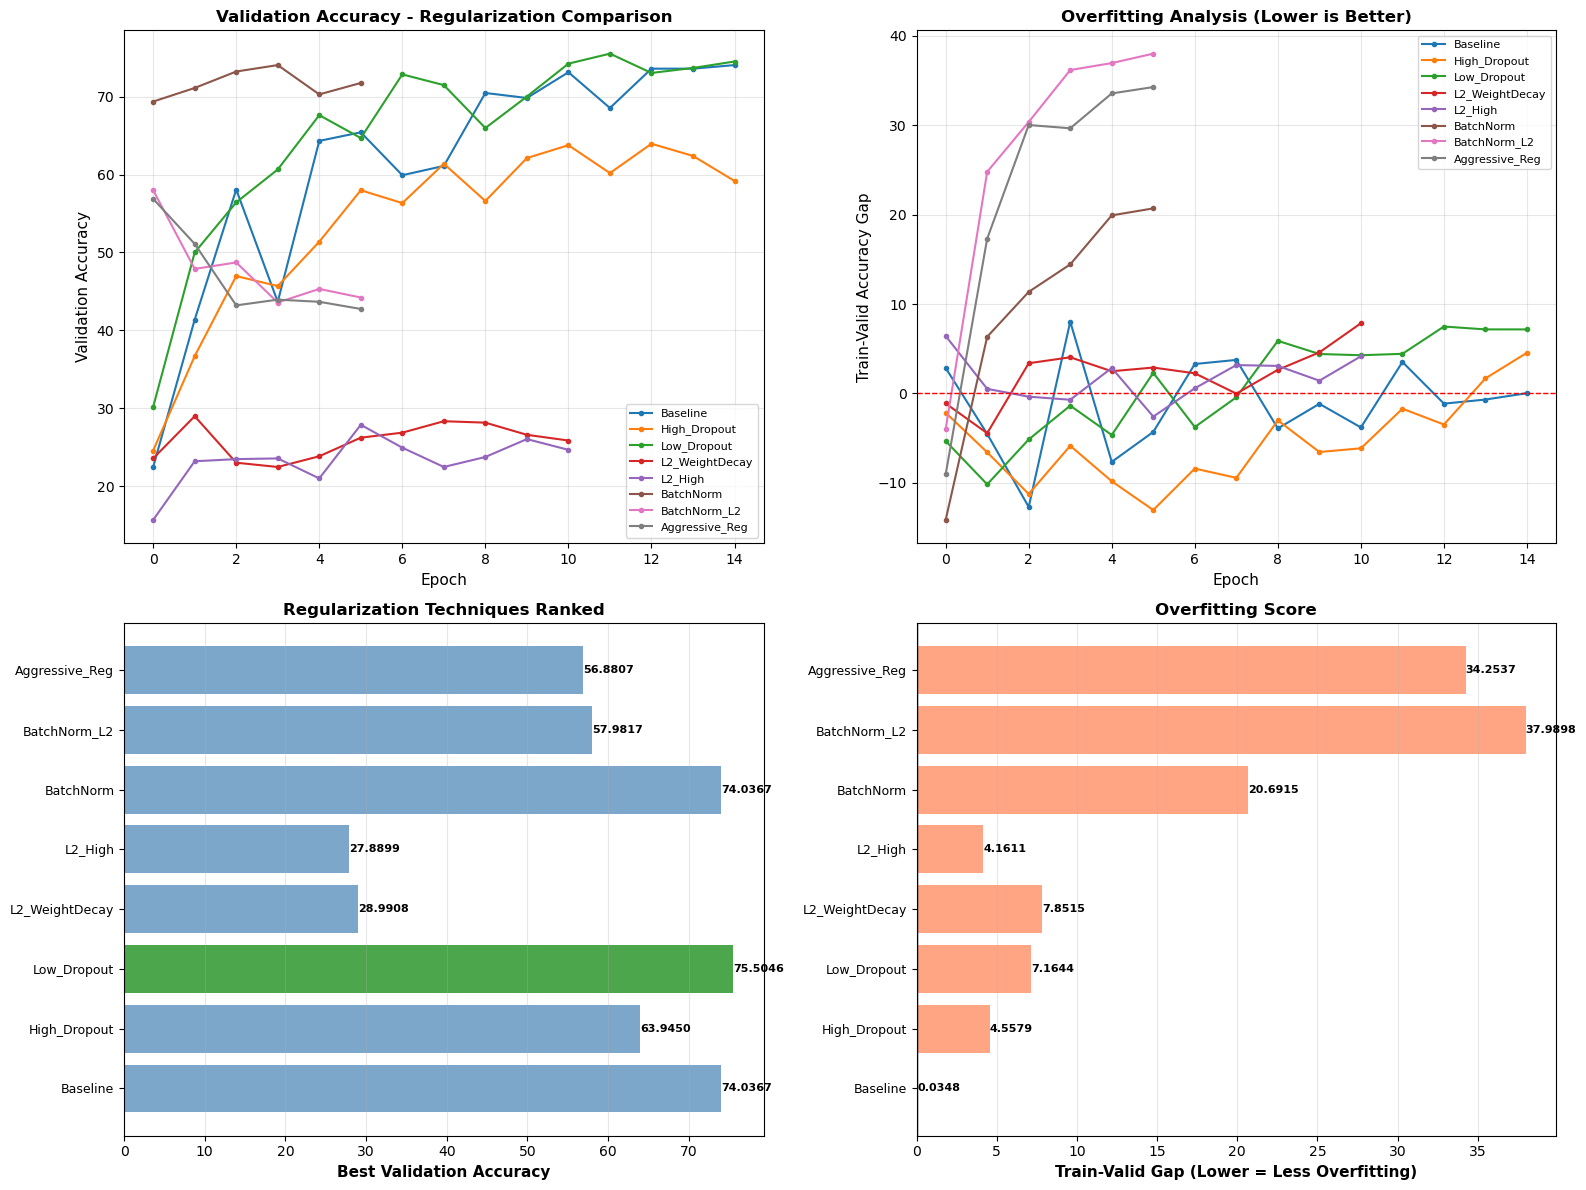

✓ Regularization comparison plotted and saved to 'regularization_comparison.png'


In [22]:
# ========== Visualize Regularization Results ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Validation Accuracy Comparison
ax = axes[0, 0]
for name, result in regularization_results.items():
    ax.plot(result['history']['valid_acc'], label=name, marker='o', markersize=3)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.set_title('Validation Accuracy - Regularization Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: Train vs Valid Accuracy (Overfitting Analysis)
ax = axes[0, 1]
for name, result in regularization_results.items():
    train_accs = result['history']['train_acc']
    valid_accs = result['history']['valid_acc']
    gap = [t - v for t, v in zip(train_accs, valid_accs)]
    ax.plot(gap, label=name, marker='o', markersize=3)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Train-Valid Accuracy Gap', fontsize=11)
ax.set_title('Overfitting Analysis (Lower is Better)', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Plot 3: Best Validation Accuracy Bar Chart
ax = axes[1, 0]
names = list(regularization_results.keys())
best_accs = [regularization_results[name]['best_valid_acc'] for name in names]
colors = ['green' if name == best_reg else 'steelblue' for name in names]
bars = ax.barh(range(len(names)), best_accs, color=colors, alpha=0.7)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Best Validation Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Regularization Techniques Ranked', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, best_accs)):
    ax.text(acc + 0.001, bar.get_y() + bar.get_height() / 2,
            f'{acc:.4f}', va='center', fontsize=8, fontweight='bold')

# Plot 4: Overfitting Score (Final Train-Valid Gap)
ax = axes[1, 1]
overfitting_scores = []
for name in names:
    result = regularization_results[name]
    final_train = result['history']['train_acc'][-1]
    final_valid = result['history']['valid_acc'][-1]
    gap = final_train - final_valid
    overfitting_scores.append(gap)

colors_over = ['green' if gap == min(overfitting_scores) else 'coral' for gap in overfitting_scores]
bars = ax.barh(range(len(names)), overfitting_scores, color=colors_over, alpha=0.7)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Train-Valid Gap (Lower = Less Overfitting)', fontsize=11, fontweight='bold')
ax.set_title('Overfitting Score', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Add value labels
for i, (bar, gap) in enumerate(zip(bars, overfitting_scores)):
    ax.text(gap + 0.001, bar.get_y() + bar.get_height() / 2,
            f'{gap:.4f}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('results/regularization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Regularization comparison plotted and saved to 'regularization_comparison.png'")

### Training Final Model with Best Configuration

In [23]:
# ========== Train Final Model with Best Configuration ==========
print("FINAL MODEL TRAINING")
print("=" * 70)

# Get best regularization config
best_reg_result = regularization_results[best_reg]
final_config = best_reg_result['config'].copy()

# Find which model class to use
best_reg_config = next(rc for rc in regularization_configs if rc['name'] == best_reg)
final_model_class = best_reg_config['model']

print(f"Best Configuration Found:")
print(f"  Optimizer: {final_config['optimizer']}")
print(f"  Learning Rate: {final_config['learning_rate']}")
print(f"  Batch Size: {final_config['batch_size']}")
print(f"  Dropout: {final_config['dropout']}")
print(f"  Weight Decay: {final_config['weight_decay']}")
print(f"  Gradient Clipping: {final_config['grad_clip']}")
print(f"  Model Architecture: {final_model_class.__name__}")
print(f"  Kernel Sizes: {final_config['kernel_sizes']}")
print(f"  Num Filters: {final_config['num_filters']}")
print("=" * 70)

# Train final model with more epochs
print("\nTraining final model with extended epochs...")

final_result = train_with_regularization(
    model_class=final_model_class,
    config=final_config,
    train_loader=best_train_loader,
    valid_loader=best_valid_loader,
    device=device,
    num_epochs=30,  # More epochs for final model
    early_stop_patience=7,  # More patience
    verbose=True
)

print("\n" + "=" * 70)
print("FINAL MODEL RESULTS")
print("=" * 70)
print(f"Best Validation Accuracy: {final_result['best_valid_acc']:.4f}")
print("=" * 70)

# Save the final model
final_model = final_model_class(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_classes=NUM_CLASSES,
    kernel_sizes=final_config['kernel_sizes'],
    num_filters=final_config['num_filters'],
    dropout=final_config['dropout']
).to(device)

final_model.load_state_dict(final_result['model_state'])
torch.save(final_model.state_dict(), 'models/final_best_cnn_model.pth')
print("\n✓ Final model saved to 'final_best_cnn_model.pth'")

FINAL MODEL TRAINING
Best Configuration Found:
  Optimizer: RMSprop
  Learning Rate: 0.002
  Batch Size: 64
  Dropout: 0.3
  Weight Decay: 0.0
  Gradient Clipping: 1.0
  Model Architecture: TextCNN
  Kernel Sizes: [3, 4, 5]
  Num Filters: 100

Training final model with extended epochs...

Config: RMSprop(lr=0.002, wd=0.0), dropout=0.3, grad_clip=1.0

Epoch  1/30 | Train: Loss=2.2809 Acc=22.9253 | Valid: Loss=1.6060 Acc=24.4037
Validation loss decreased (inf --> 1.605996). Saving model ...
Epoch  2/30 | Train: Loss=1.4237 Acc=40.4402 | Valid: Loss=1.3704 Acc=44.8624
Validation loss decreased (1.605996 --> 1.370397). Saving model ...
Epoch  3/30 | Train: Loss=1.1973 Acc=53.4388 | Valid: Loss=1.1132 Acc=54.3119
Validation loss decreased (1.370397 --> 1.113214). Saving model ...
Epoch  4/30 | Train: Loss=1.0403 Acc=58.8721 | Valid: Loss=1.1231 Acc=50.8257
EarlyStopping counter: 1 out of 7
Epoch  5/30 | Train: Loss=0.9513 Acc=63.4571 | Valid: Loss=0.8219 Acc=67.7064
Validation loss decrease

Plotting training loss and validation accuracy for the Best Model (TextCNN_BN)...


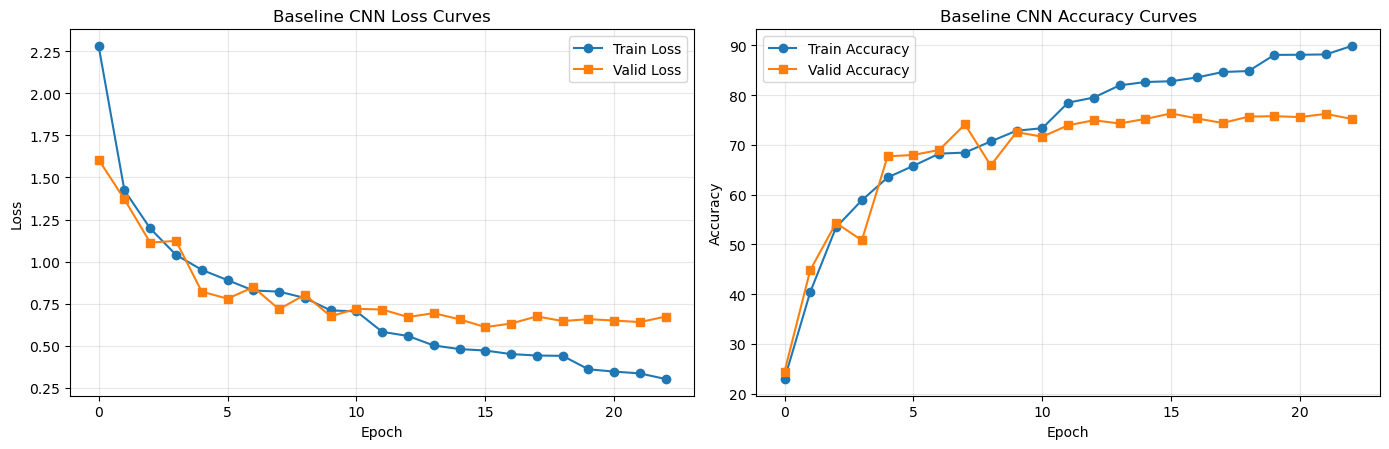

In [24]:
# ======================================================================
# ## Plot: Final Best Model Training Dynamics
# ======================================================================
#
# Plotting the training loss and validation accuracy curves
# for the best model from hyperparameter tuning (TextCNN_BN)
# as requested by Q2(c) / Q3(b).

print("Plotting training loss and validation accuracy for the Best Model (TextCNN_BN)...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(final_result['history']['train_loss'], label='Train Loss', marker='o')
ax1.plot(final_result['history']['valid_loss'], label='Valid Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Baseline CNN Loss Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(final_result['history']['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(final_result['history']['valid_acc'], label='Valid Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Baseline CNN Accuracy Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('results/final_best_model_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
# ========== Evaluate Final Model on Test Set ==========
print("Evaluating final model on test set...")

# Create test loader with best batch size
# Use the Dataset object we created in the main setup cell
final_test_loader = DataLoader(test_dataset, batch_size=final_config['batch_size'],
                               shuffle=False, collate_fn=collate_batch)

criterion = nn.CrossEntropyLoss()

# Evaluate
test_loss, test_acc, test_preds, test_labels = evaluate(
    final_model, final_test_loader, criterion, device
)

print("\n" + "=" * 70)
print("FINAL MODEL - TEST SET EVALUATION")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("=" * 70)

# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 70)
target_names = [idx2label[i] for i in range(NUM_CLASSES)]
print(classification_report(test_labels, test_preds, target_names=target_names, digits=4))

Evaluating final model on test set...

FINAL MODEL - TEST SET EVALUATION
Test Loss: 0.4972
Test Accuracy: 83.2000

Detailed Classification Report:
              precision    recall  f1-score   support

        ENTY     0.7887    0.5957    0.6788        94
         HUM     0.7763    0.9077    0.8369        65
        DESC     0.8165    0.9348    0.8716       138
         NUM     0.9505    0.8496    0.8972       113
         LOC     0.8000    0.8889    0.8421        81
        ABBR     1.0000    0.4444    0.6154         9

    accuracy                         0.8320       500
   macro avg     0.8553    0.7702    0.7903       500
weighted avg     0.8370    0.8320    0.8272       500



### Final Test Set Evaluation

In [26]:
# Comprehensive Experiment Summary
import pandas as pd

print("\n" + "=" * 90)
print(" " * 30 + "EXPERIMENT SUMMARY")
print("=" * 90)

# Experiment 1: Optimizer Comparison
print("\nEXPERIMENT 1: Optimizer Comparison")
print("-" * 90)
opt_data = []
for name, result in optimizer_results.items():
    opt_data.append({
        'Optimizer': name,
        'Best Valid Acc': f"{result['best_valid_acc']:.4f}",
        'Final Train Acc': f"{result['history']['train_acc'][-1]:.4f}",
        'Epochs Trained': len(result['history']['train_acc'])
    })
opt_df = pd.DataFrame(opt_data)
print(opt_df.to_string(index=False))

# Experiment 2: Grid Search
print("\n\nEXPERIMENT 2: Batch Size & Learning Rate Tuning")
print("-" * 90)
grid_data = []
for name, result in sorted(grid_search_results.items(),
                           key=lambda x: x[1]['best_valid_acc'],
                           reverse=True)[:5]:  # Top 5
    config = result['config']
    grid_data.append({
        'Config': name,
        'Best Valid Acc': f"{result['best_valid_acc']:.4f}",
        'Batch Size': config['batch_size'],
        'Learning Rate': config['learning_rate']
    })
grid_df = pd.DataFrame(grid_data)
print("Top 5 Configurations:")
print(grid_df.to_string(index=False))

# Experiment 3: Regularization
print("\n\nEXPERIMENT 3: Regularization Techniques")
print("-" * 90)
reg_data = []
for name, result in sorted(regularization_results.items(),
                           key=lambda x: x[1]['best_valid_acc'],
                           reverse=True):
    config = result['config']
    final_train = result['history']['train_acc'][-1]
    gap = final_train - result['best_valid_acc']
    reg_data.append({
        'Technique': name,
        'Valid Acc': f"{result['best_valid_acc']:.4f}",
        'Train-Valid Gap': f"{gap:.4f}",
        'Dropout': config['dropout'],
        'Weight Decay': config['weight_decay']
    })
reg_df = pd.DataFrame(reg_data)
print(reg_df.to_string(index=False))

# Final Summary
print("\n\n" + "=" * 90)
print(" " * 35 + "FINAL RESULTS")
print("=" * 90)
print(f"\nBest Configuration Found:")
print(f"   - Optimizer: {final_config['optimizer']}")
print(f"   - Learning Rate: {final_config['learning_rate']}")
print(f"   - Batch Size: {final_config['batch_size']}")
print(f"   - Dropout: {final_config['dropout']}")
print(f"   - Weight Decay: {final_config['weight_decay']}")
print(f"   - Gradient Clipping: {final_config['grad_clip']}")
print(f"   - Model: {final_model_class.__name__}")

print(f"\nPerformance Metrics:")
print(f"   - Best Validation Accuracy: {final_result['best_valid_acc']:.4f}")
print(f"   - Test Accuracy: {test_acc:.4f}")
print(f"   - Total Epochs Trained: {len(final_result['history']['train_acc'])}")

print("\n" + "=" * 90)



                              EXPERIMENT SUMMARY

EXPERIMENT 1: Optimizer Comparison
------------------------------------------------------------------------------------------
   Optimizer Best Valid Acc Final Train Acc  Epochs Trained
        Adam        73.4862         76.5179              15
SGD_Momentum        65.8716         56.7232              15
     RMSprop        74.1284         73.3393              15


EXPERIMENT 2: Batch Size & Learning Rate Tuning
------------------------------------------------------------------------------------------
Top 5 Configurations:
       Config Best Valid Acc  Batch Size  Learning Rate
 BS64_LR0.002        77.5229          64         0.0020
BS64_LR0.0005        76.6972          64         0.0005
 BS32_LR0.001        76.4220          32         0.0010
BS32_LR0.0005        76.0550          32         0.0005
 BS32_LR0.002        75.0459          32         0.0020


EXPERIMENT 3: Regularization Techniques
------------------------------------------